# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline

# Coordinates transformation

In [2]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

# Open file

This code opens 1 files, reads line by line and returns a list of floats for each line.

In [3]:
'''data_file = "../data/calibration/Run000260/data_000000.txt"
with open(data_file) as f:
    for line in f:
        event = line.split()
        event = [float(i) for i in event]
        print(event)'''

'data_file = "../data/calibration/Run000260/data_000000.txt"\nwith open(data_file) as f:\n    for line in f:\n        event = line.split()\n        event = [float(i) for i in event]\n        print(event)'

Let's just use 1 line, in order to test the code.

In [3]:
data_file = "../data/calibration/Run000260/data_000000.txt"
with open(data_file) as f:
    line = f.readline()
    line = f.readline()
    line = f.readline()
    line = f.readline()
    line = f.readline()
    event = line.split()
    #event = [float(i) for i in event]
    print(event)

['5', '11', '2', '2', '7.695e+01', '9.105e+01', '130.8', '2', '3', '4.967e+01', '7.633e+01', '247.5', '2', '4', '7.494e+01', '9.306e+01', '168.3', '2', '1', '4.833e+01', '7.767e+01', '272.5', '3', '4', '4.160e+01', '4.240e+01', '7.5', '3', '3', '1.869e+02', '1.911e+02', '39.2', '3', '2', '4.065e+01', '4.335e+01', '25.0', '3', '1', '1.421e+02', '1.519e+02', '91.7', '3', '4', '1.532e+02', '1.828e+02', '275.0', '3', '1', '4.362e+01', '8.238e+01', '360.0', '3', '3', '4.312e+01', '8.288e+01', '369.2']


# Read data

- **Input**: 1 row of data_file.txt, e.g. 1 event, passed as a `list`
- **Output**: pandas dataframe as in the *Data Format* paragraph, Number of the Event, Number of hits in the Event

This function takes in input one event at time, and then outputs a pandas dataframe as described in the previous section. In addition, the transformation from local to global coordinates is performed.

In [17]:
def read_data(event):    
    event_number = int(event[0])
    hits_number  = int(event[1])
    hit       = np.arange(hits_number)
    chamber   = np.fromiter((event[2+5*i] for i in range(hits_number)), int)
    layer     = np.fromiter((event[3+5*i] for i in range(hits_number)), int)
    xl_local  = np.fromiter((event[4+5*i] for i in range(hits_number)), float)
    xr_local  = np.fromiter((event[5+5*i] for i in range(hits_number)), float)
    z_local   = np.fromiter((local_z_shifts[i-1]+ZCELL/2 for i in layer), float)
    time      = np.fromiter((event[6+5*i] for i in range(hits_number)), float)
    xl_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xl_local
    xr_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xr_local
    z_global  = np.fromiter((global_z_shifts[i] for i in chamber), float) + z_local
    dataframe = pd.DataFrame(
        { 'EvNumber' : event_number,
          'Hit'      : hit,
          'Chamber'  : chamber,
          'Layer'    : layer,
          'XL_local' : xl_local,
          'XR_local' : xr_local,
          'Z_local'  : z_local,
          'Time'     : time,
          'XL_global': xl_global,
          'XR_global': xr_global,
          'Z_global' : z_global,
        })
    #dataframe.set_index('Hit', inplace=True) # set as index the number of the hit 
    return dataframe, event_number, hits_number

ev, evNumber, hits = read_data(event)
ev["EvNumber"][0]

5

# Plot background

- **Input**: `None`
- **Output**: `list`\[pyplot `Axes`\] (global image + 4 detectors zooms)

The input of the function is the pandas dataframe made by the *Read Data* function. Five plots are given as output: one image of the whole detector, and one for each of the 4 chambers. In the images there will be the points of the hits tracked in the event (left/right positions must have different colors).

Instead of having 4 different 2D numpy arrays with the coordinates of the vertices of the 4 chambers, we create a pandas DataFrame with the following columns:

| chamber | x_vertices | y_vertices |
| --- | --- | --- |

where *x_vertices*, *y_vertices* contain a list with the four x/y coordinates of the 4 vertices of the chamber.

In [5]:
def plot_background():
    # create Pandas DataFrame for the cambers positions
    chamber_position = pd.DataFrame({
    'chamber' : [i for i in range(4)],
    'x_vertices' : [(global_x_shifts[i], global_x_shifts[i] - 720, global_x_shifts[i] - 720, global_x_shifts[i])
                    for i in range(4)],
    'y_vertices' : [(global_z_shifts[i], global_z_shifts[i], global_z_shifts[i] + 52, global_z_shifts[i] + 52)
                    for i in range(4)],
    })
    x_lim = [[-1000, 1000], # global detector
             [    0, 1000], # chamber 0
             [    0, 1000], # chamber 1
             [-1000,    0], # chamber 2
             [-1000,    0]] # chamber 3
    y_lim = [[-100, 1000],  # global detector
             [800 ,  900],  # chamber 0
             [ -25,   75],  # chamber 1
             [ 800,  900],  # chamber 2
             [ -25,   75]]  # chamber 3
    title = ["DETECTOR", "Chamber 0", "Chamber 1", "Chamber 2", "Chamber 3"]
    # create pyplot 'Axes' objects
    ax_global = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax_0 = plt.subplot2grid(gridsize, (2, 1), colspan=1, rowspan=1) # top-right
    ax_1 = plt.subplot2grid(gridsize, (3, 1), colspan=1, rowspan=1) # bottom-right
    ax_2 = plt.subplot2grid(gridsize, (2, 0), colspan=1, rowspan=1) # top-left
    ax_3 = plt.subplot2grid(gridsize, (3, 0), colspan=1, rowspan=1) # bottom-left
    
    axes = [ax_global, ax_0, ax_1, ax_2, ax_3]
    for index, ax in enumerate(axes):
        ax.set_xlim(x_lim[index])
        ax.set_ylim(y_lim[index])
        ax.set_xlabel("x [mm]")
        ax.set_ylabel("z [mm]")
        if index == 0: ax.set_title(title[index])
        else: ax.set_title(title[index], pad=-20)
        # plot the 4 chambers in each 'Axes'
        for j in range(4):
            chamber = chamber_position[chamber_position["chamber"] == j]
            ax.fill(chamber["x_vertices"].values[0], chamber["y_vertices"].values[0], color='gray', fill=False)
    return axes
    

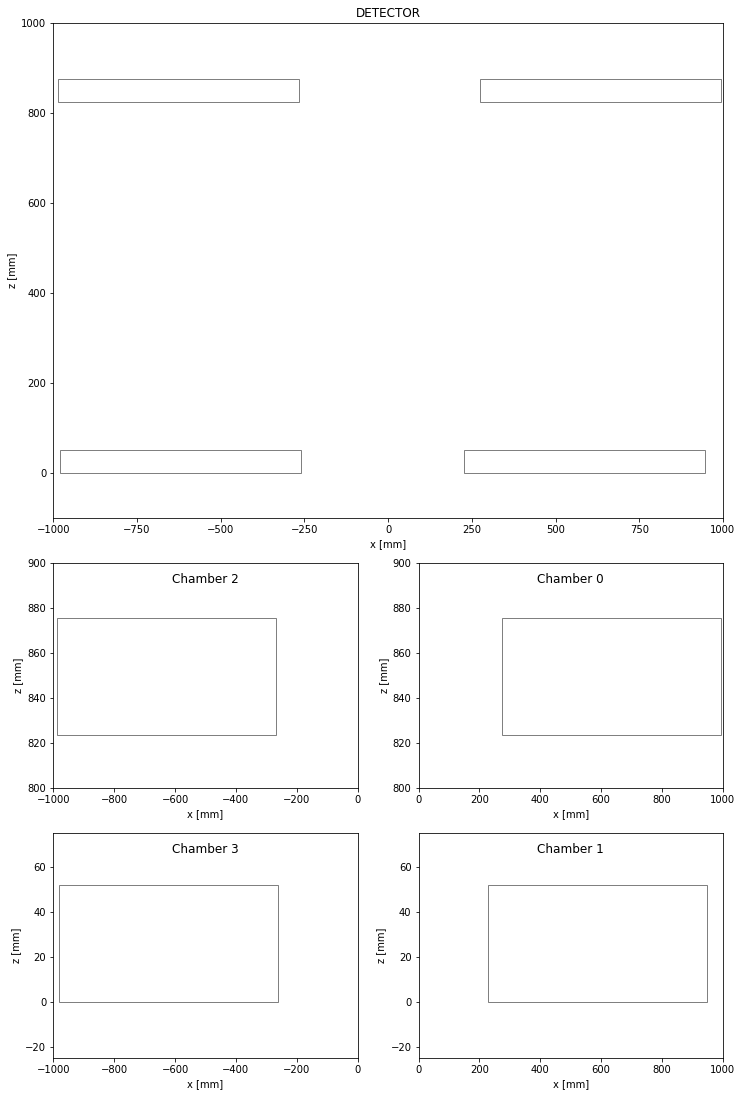

In [6]:
gridsize = (5, 2)
fig = plt.figure(figsize = (12, 24))
axes = plot_background()
plt.show()

# Plot events

- **Input**: Pandas `DataFrame` (1 event) + `list`\[pyplot `Axes`\]
- **Output**: `list`\[pyplot `Axes`\] (global image + 4 detectors zooms)

The input of the function is the Pandas `DataFrame` made by the *Read Data* function, and the `list` of the background images created by *Plot background* function. Five plots are given as output: one image of the whole detector, and one for each of the 4 chambers. In the images there will be the points of the hits tracked in the event (left/right positions must have different colors).

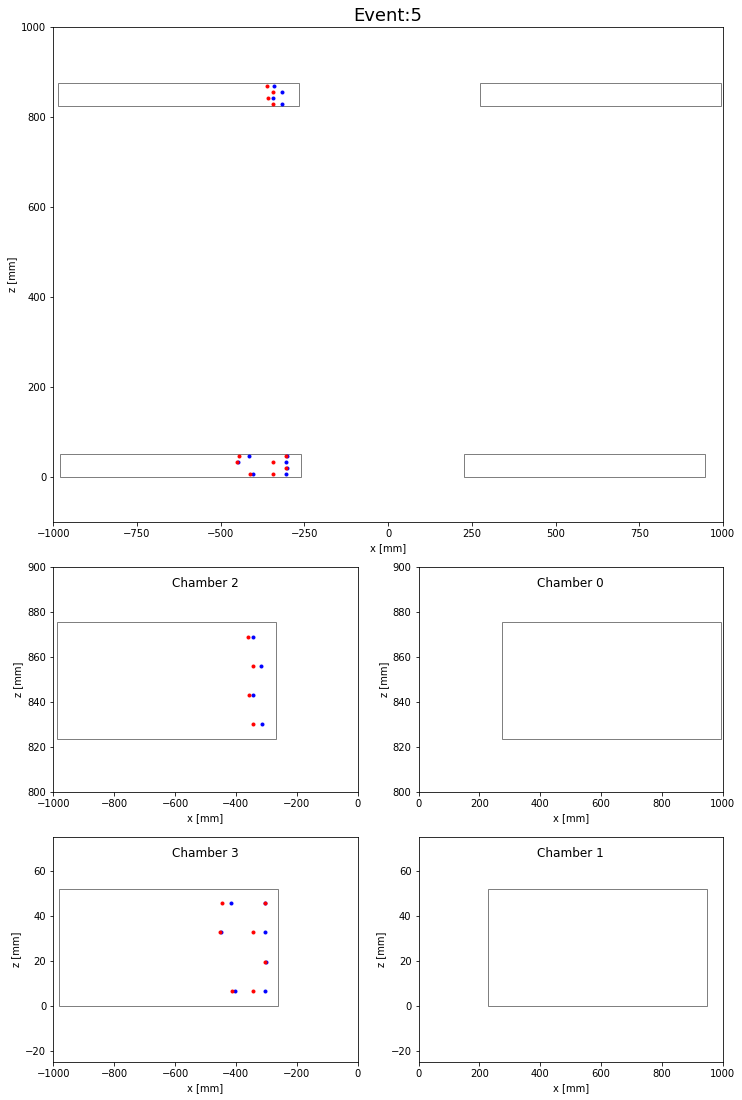

In [38]:
def plot_events(dataframe, background):
    for index, image in enumerate(background):
        image.plot(dataframe["XL_global"], dataframe["Z_global"], "bo", markersize=3)
        image.plot(dataframe["XR_global"], dataframe["Z_global"], "ro", markersize=3)
        if index == 0:
            evN = dataframe["EvNumber"][0]
            image.set_title("Event:"+str(evN), {'size':'18'})
    return background

gridsize = (5, 2)
fig = plt.figure(figsize = (12, 24))
axes = plot_background()
axes = plot_events(ev, axes)
plt.show()